<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html GenerativeAdversarialNetworks.do.txt  -->

# Generative Models
**Generative models** describe a class of statistical models that are a contrast
to **discriminative models**. Informally we say that generative models can
generate new data instances while discriminative models discriminate between
different kinds of data instances. A generative model could generate new photos
of animals that look like 'real' animals while a discriminative model could tell
a dog from a cat. More formally, given a data set $x$ and a set of labels /
targets $y$. Generative models capture the joint probability $p(x, y)$, or
just $p(x)$ if there are no labels, while discriminative models capture the
conditional probability $p(y | x)$. Discriminative models generally try to draw
boundaries in the data space (often high dimensional), while generative models
try to model how data is placed throughout the space.

## Generative Adversarial Networks
**Generative Adversarial Networks** are a type of unsupervised machine learning
algorithm proposed by [Goodfellow et. al](https://arxiv.org/pdf/1406.2661.pdf)
in 2014 (Read the paper first it's only 6 pages). The simplest formulation of
the model is based on a game theoretic approach, *zero sum game*, where we pit
two neural networks against one another. We define two rival networks, one
generator $g$, and one discriminator $d$. The generator directly produces
samples

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
    x = g(z; \theta^{(g)})
\label{_auto1} \tag{1}
\end{equation}
$$

The discriminator attempts to distinguish between samples drawn from the
training data and samples drawn from the generator. In other words, it tries to
tell the difference between the fake data produced by $g$ and the actual data
samples we want to do prediction on. The discriminator outputs a probability
value given by

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
    d(x; \theta^{(d)})
\label{_auto2} \tag{2}
\end{equation}
$$

indicating the probability that $x$ is a real training example rather than a
fake sample the generator has generated. The simplest way to formulate the
learning process in a generative adversarial network is a zero-sum game, in
which a function

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
    v(\theta^{(g)}, \theta^{(d)})
\label{_auto3} \tag{3}
\end{equation}
$$

determines the reward for the discriminator, while the generator gets the
conjugate reward

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
    -v(\theta^{(g)}, \theta^{(d)})
\label{_auto4} \tag{4}
\end{equation}
$$

During learning both of the networks maximize their own reward function, so that
the generator gets better and better at tricking the discriminator, while the
discriminator gets better and better at telling the difference between the fake
and real data. The generator and discriminator alternate on which one trains at
one time (i.e. for one epoch). In other words, we keep the generator constant
and train the discriminator, then we keep the discriminator constant to train
the generator and repeat. It is this back and forth dynamic which lets GANs
tackle otherwise intractable generative problems. As the generator improves with
 training, the discriminator's performance gets worse because it cannot easily
 tell the difference between real and fake. If the generator ends up succeeding
 perfectly, the the discriminator will do no better than random guessing i.e.
 50\%. This progression in the training poses a problem for the convergence
 criteria for GANs. The discriminator feedback gets less meaningful over time,
 if we continue training after this point then the generator is effectively
 training on junk data which can undo the learning up to that point. Therefore,
 we stop training when the discriminator starts outputting $1/2$ everywhere.
 At convergence we have

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
    g^* = \underset{g}{\mathrm{argmin}}\hspace{2pt}
          \underset{d}{\mathrm{max}}v(\theta^{(g)}, \theta^{(d)})
\label{_auto5} \tag{5}
\end{equation}
$$

The default choice for $v$ is

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
    v(\theta^{(g)}, \theta^{(d)}) = \mathbb{E}_{x\sim p_\mathrm{data}}\log d(x)
                                  + \mathbb{E}_{x\sim p_\mathrm{model}}
                                  \log (1 - d(x))
\label{_auto6} \tag{6}
\end{equation}
$$

The main motivation for the design of GANs is that the learning process requires
neither approximate inference (variational autoencoders for example) nor
approximation of a partition function. In the case where

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
    \underset{d}{\mathrm{max}}v(\theta^{(g)}, \theta^{(d)})
\label{_auto7} \tag{7}
\end{equation}
$$

is convex in $\theta^{(g)} then the procedure is guaranteed to converge and is
asymptotically consistent
( [Seth Lloyd on QuGANs](https://arxiv.org/pdf/1804.09139.pdf)  ). This is in
general not the case and it is possible to get situations where the training
process never converges because the generator and discriminator chase one
another around in the parameter space indefinitely. A much deeper discussion on
the currently open research problem of GAN convergence is available
[here](https://www.deeplearningbook.org/contents/generative_models.html). To
anyone interested in learning more about GANs it is a highly recommended read.
Direct quote: "In this best-performing formulation, the generator aims to
increase the log probability that the discriminator makes a mistake, rather than
aiming to decrease the log probability that the discriminator makes the correct
prediction." [Another interesting read](https://arxiv.org/abs/1701.00160)

## Writing Our First Generative Adversarial Network
Let us now move on to actually implementing a GAN in tensorflow. We will study
the performance of our GAN on the MNIST dataset. This code is based on and
adapted from the
[google tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

First we import our libraries

In [1]:
%matplotlib inline

import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

Next we define our hyperparameters and import our data the usual way

In [2]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 30

data = tf.keras.datasets.mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = data
train_images = np.reshape(train_images, (train_images.shape[0],
                                         28,
                                         28,
                                         1)).astype('float32')

# we normalize between -1 and 1
train_images = (train_images - 127.5) / 127.5
training_dataset = tf.data.Dataset.from_tensor_slices(
                      train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Let's have a quick look

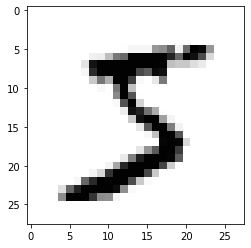

In [3]:
plt.imshow(train_images[0], cmap='Greys')
plt.show()

Now we define our two models. This is where the 'magic' happens. There are a
huge amount of possible formulations for both models. A lot of engineering and
trial and error can be done here to try to produce better performing models. For
more advanced GANs this is by far the step where you can 'make or break' a
model.

We start with the generator. As stated in the introductory text the generator
$g$ upsamples from a random sample to the shape of what we want to predict. In
our case we are trying to predict MNIST images ($28\times 28$ pixels).

In [4]:
def generator_model():
    """
    The generator uses upsampling layers tf.keras.layers.Conv2DTranspose() to
    produce an image from a random seed. We start with a Dense layer taking this
    random sample as an input and subsequently upsample through multiple
    convolutional layers.
    """

    # we define our model
    model = tf.keras.Sequential()


    # adding our input layer. Dense means that every neuron is connected and
    # the input shape is the shape of our random noise. The units need to match
    # in some sense the upsampling strides to reach our desired output shape.
    # we are using 100 random numbers as our seed
    model.add(layers.Dense(units=7*7*BATCH_SIZE,
                           use_bias=False,
                           input_shape=(100, )))
    # we normalize the output form the Dense layer
    model.add(layers.BatchNormalization())
    # and add an activation function to our 'layer'. LeakyReLU avoids vanishing
    # gradient problem
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, BATCH_SIZE)))
    assert model.output_shape == (None, 7, 7, BATCH_SIZE)
    # even though we just added four keras layers we think of everything above
    # as 'one' layer

    # next we add our upscaling convolutional layers
    model.add(layers.Conv2DTranspose(filters=128,
                                     kernel_size=(5, 5),
                                     strides=(1, 1),
                                     padding='same',
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 7, 7, 128)

    model.add(layers.Conv2DTranspose(filters=64,
                                     kernel_size=(5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 14, 14, 64)

    model.add(layers.Conv2DTranspose(filters=1,
                                     kernel_size=(5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False,
                                     activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

And there we have our 'simple' generator model. Now we move on to defining our
discriminator model $d$, which is a convolutional neural network based image
classifier.

In [5]:
def discriminator_model():
    """
    The discriminator is a convolutional neural network based image classifier
    """

    # we define our model
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=64,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    # adding a dropout layer as you do in conv-nets
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(filters=128,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding='same'))
    model.add(layers.LeakyReLU())
    # adding a dropout layer as you do in conv-nets
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Let us take a look at our models. **Note**: double click images for bigger view.

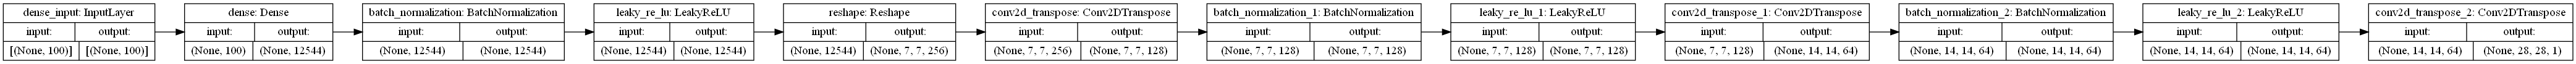

In [6]:
generator = generator_model()
plot_model(generator, show_shapes=True, rankdir='LR')

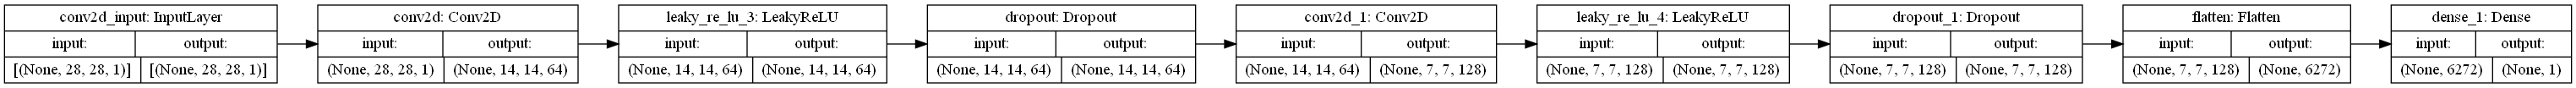

In [7]:
discriminator = discriminator_model()
plot_model(discriminator, show_shapes=True, rankdir='LR')

Next we need a few helper objects we will use in training

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

The first object, *cross_entropy* is our loss function and the two others are
our optimizers. Notice we use the same learning rate for both $g$ and $d$. This
is because they need to improve their accuracy at approximately equal speeds to
get convergence (not necessarily exactly equal). Now we define our loss
functions

In [9]:
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    return loss

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_liks(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

Next we define a kind of seed to help us compare the learning process over
multiple training epochs.

In [11]:
noise_dimension = 100
n_examples_to_generate = 16
seed_images = tf.random.normal([n_examples_to_generate, noise_dimension])

Now we have everything we need to define our training step, which we will apply
for every step in our training loop. Notice the @tf.function flag signifying
that the function is tensorflow 'compiled'. Removing this flag doubles the
computation time.

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                            discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                            discriminator.trainable_variables))

    return gen_loss, disc_loss

Next we define a helper function to produce an output over our training epochs
to see the predictive progression of our generator model. **Note**: I am including
this code here, but comment it out in the training loop.

In [13]:
def generate_and_save_images(model, epoch, test_input):
    # we're making inferences here
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'./images_from_seed_images/image_at_epoch_{str(epoch).zfill(3)}.png')
    plt.close()
    #plt.show()

Setting up checkpoints to periodically save our model during training so that
everything is not lost even if the program were to somehow terminate while
training.

In [14]:
# Setting up checkpoints to save model during training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)

Now we define our training loop

In [15]:
def train(dataset, epochs):
    generator_loss_list = []
    discriminator_loss_list = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            generator_loss_list.append(gen_loss.numpy())
            discriminator_loss_list.append(disc_loss.numpy())

        #generate_and_save_images(generator, epoch + 1, seed_images)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch} is {time.time() - start}')

    #generate_and_save_images(generator, epochs, seed_images)

    loss_file = './data/lossfile.txt'
    with open(loss_file, 'w') as outfile:
        outfile.write(str(generator_loss_list))
        outfile.write('\n')
        outfile.write('\n')
        outfile.write(str(discriminator_loss_list))
        outfile.write('\n')
        outfile.write('\n')

To train simply call this function. **Warning**: this might take a long time so
there is a folder of a pretrained network already included in the repository.

In [16]:
train(train_dataset, EPOCHS)

And here is the result of training our model for 100 epochs

<!-- dom:MOVIE: [images_from_seed_images/generation.gif] -->
<!-- begin movie -->

In [17]:
from IPython.display import HTML
_s = """
<embed src="images_from_seed_images/generation.gif"  autoplay="false" loop="true"></embed>
<p><em></em></p>
"""
HTML(_s)

<!-- end movie -->

Now to avoid having to train and everything, which will take a while depending
on your computer setup we now load in the model which produced the above gif.

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
restored_generator = checkpoint.generator
restored_discriminator = checkpoint.discriminator

print(restored_generator)
print(restored_discriminator)

## Exploring the Latent Space

So we have successfully loaded in our latest model. Let us now play around a bit
and see what kind of things we can learn about this model. Our generator takes
an array of 100 numbers. One idea can be to try to systematically change our
input. Let us try and see what we get

In [62]:
def generate_latent_points(number=100, scale_means=1, scale_stds=1):
    latent_dim = 100
    means = scale_means * tf.linspace(-1, 1, num=latent_dim)
    stds = scale_stds * tf.linspace(-1, 1, num=latent_dim)
    latent_space_value_range = tf.random.normal([number, latent_dim],
                                                means,
                                                stds,
                                                dtype=tf.float64)

    return latent_space_value_range

def generate_images(latent_points):
    # notice we set training to false because we are making inferences
    generated_images = restored_generator.predict(latent_points)

    return generated_images

In [63]:
def plot_result(generated_images, number=100):
    # obviously this assumes sqrt number is an int
    fig, axs = plt.subplots(int(np.sqrt(number)), int(np.sqrt(number)),
                            figsize=(10, 10))

    for i in range(int(np.sqrt(number))):
        for j in range(int(np.sqrt(number))):
            axs[i, j].imshow(generated_images[i*j], cmap='Greys')
            axs[i, j].axis('off')

    plt.show()

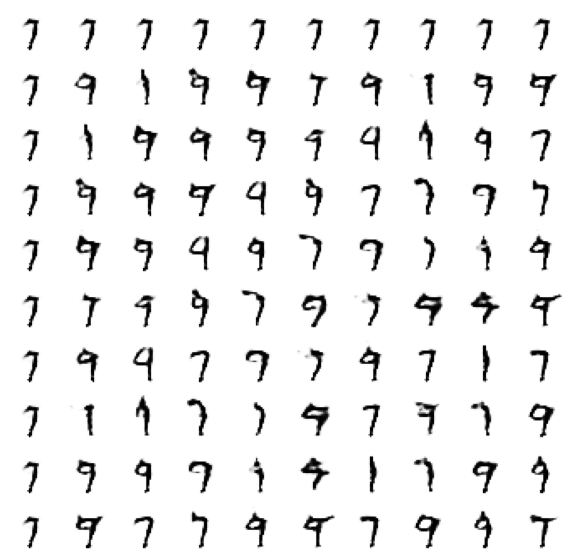

In [64]:
generated_images = generate_images(generate_latent_points())
plot_result(generated_images)

Interesting! We see that the generator generates images that look like MNIST
numbers: $1, 4, 7, 9$. Let's try to tweak it a bit more to see if we are able
to generate a similar plot where we generate every MNIST number. Let us now try
to 'move' a bit around in the latent space. **Note**: decrease the plot number if
these following cells take too long to run on your computer.

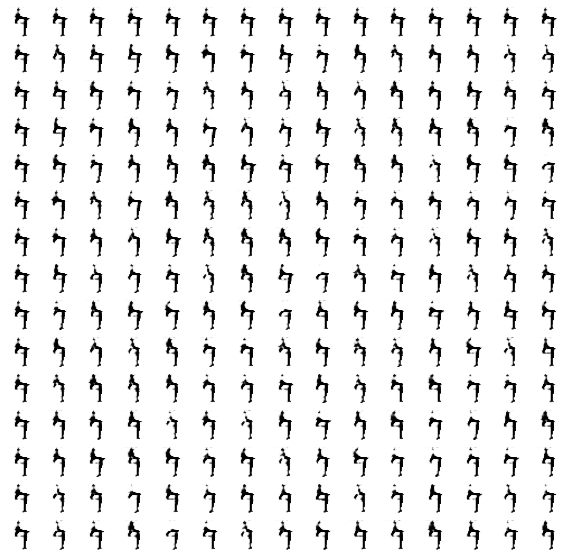

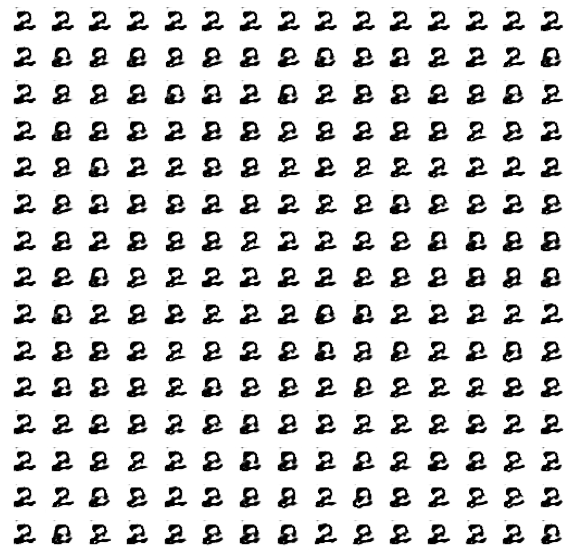

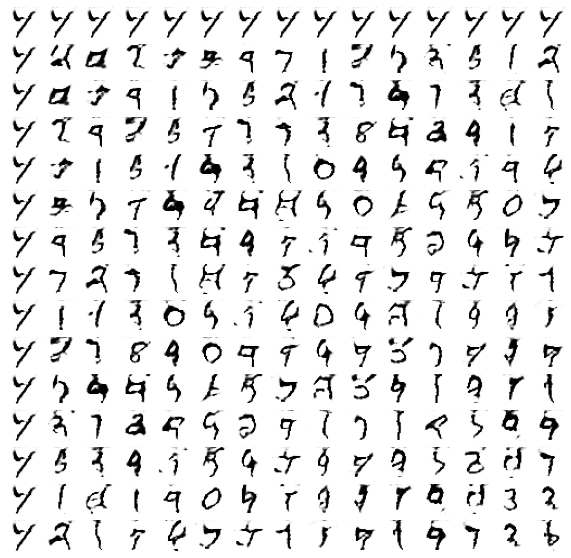

In [65]:
plot_number = 225

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=5,
                                                          scale_stds=1))
plot_result(generated_images, number=plot_number)

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=-5,
                                                          scale_stds=1))
plot_result(generated_images, number=plot_number)

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=1,
                                                          scale_stds=5))
plot_result(generated_images, number=plot_number)

Again, we have found something interesting. *Moving* around using our means
takes us from digit to digit, while *moving* around using our standard
deviations seem to increase the number of different digits! In the last image
above, we can barely make out every MNIST digit. Let us make on last plot using
this information by upping the standard deviation of our Gaussian noises.

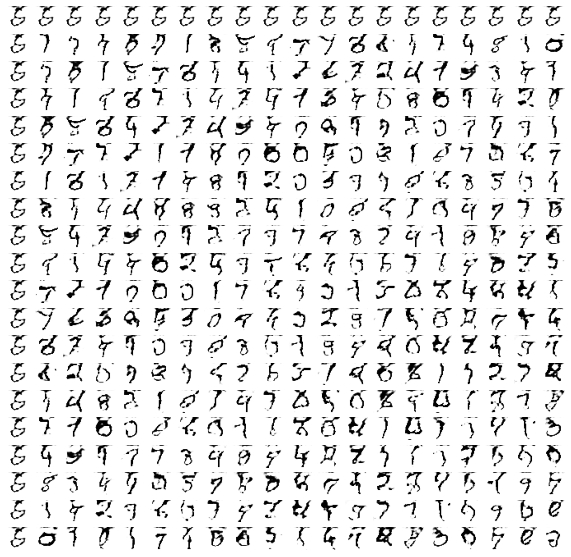

In [66]:
plot_number = 400
generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=1,
                                                          scale_stds=10))
plot_result(generated_images, number=plot_number)


A pretty cool result! We see that our generator indeed has learned a
distribution which qualitatively looks a whole lot like the MNIST dataset.

## Interpolating Between MNIST Digits
Another interesting way to explore the latent space of our generator model is by
interpolating between the MNIST digits. This section is largely based on
"this excellent blogpost": <https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/>
by Jason Brownlee.

So let us start by defining a function to interpolate between two points in the
latent space.

In [76]:
def interpolation(point_1, point_2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = []
    for i, ratio in enumerate(ratios):
        vectors.append(((1.0 - ratio) * point_1 + ratio * point_2))

    return np.asarray(vectors)

Now we have all we need to do our interpolation analysis.

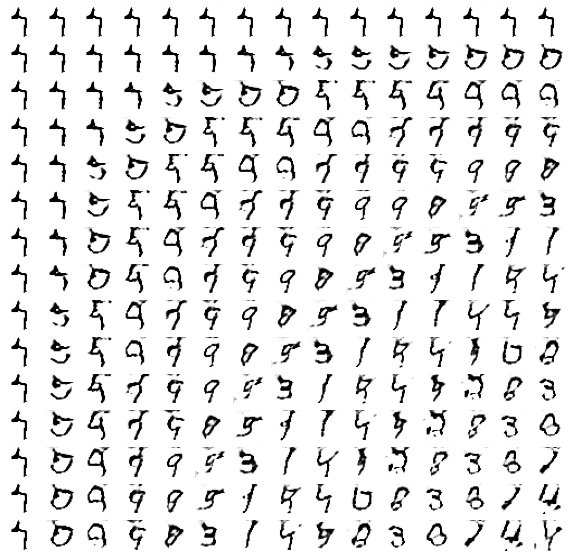

In [81]:
plot_number = 225
sqrt_plot_number = int(np.sqrt(plot_number))
latent_points = generate_latent_points(number=plot_number, scale_stds=7.5)
results = None
for i in range(0, 2*sqrt_plot_number, 2):
    interpolated = interpolation(latent_points[i], latent_points[i+1], sqrt_plot_number)
    generated_images = generate_images(interpolated)
    
    if results is None:
        results = generated_images
    else:
        results = np.vstack((results, generated_images))

plot_result(results, plot_number)